In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
import scipy, pylab
import sys

In [3]:
def peak_normalize(data):
    max_data = max(abs(data))
    return data/(max_data*1.0)

def stft(x, framesz, hop):
    w = scipy.hanning(framesz)
    X = scipy.array([scipy.fft(w*x[i:i+framesz]) 
                     for i in range(0, len(x)-framesz, hop)])
    return X

def istft(X, fs, T, hop):
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

def sample_frames(X, L, H):
    n_hops = int(round((len(X) - L) / H))
    Y = []
    for hop in range(0, n_hops):
        hop_start = (hop * H) + 1  
        Y.append(list(np.array(X[hop_start:hop_start + L]).flat))    
    return np.array(Y)

In [4]:
L = 20 # number of stacked frames
H = 60 # Training data resample hop
K = 1500 # number of NMF basis
P = 1 # exponent for ratio mask (NMF)
N_BINS = 1025 # number of FFT bins
FFT_SIZE = 2 * (N_BINS-1) # STFT FFT size
HOP_SIZE = 512 # STFT hop size
N_ITER = 100 # number of iterations
SAMPLE_FREQUENCY = 44100 # 44.1 kHz
N_EPOCHS = 1

C:\Users\Artur\Anaconda\lib\site-packages\scipy\io\wavfile.py:179: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
C:\Users\Artur\Anaconda\lib\site-packages\scipy\io\wavfile.py:42: WavFileWarning: Unknown wave file format
  warnings.warn("Unknown wave file format", WavFileWarning)


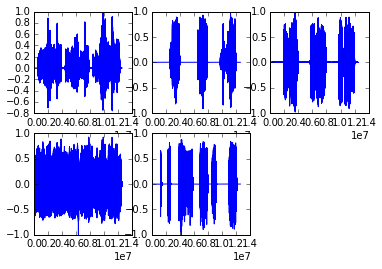

In [5]:
vocals = []
non_vocals = []

rate_01, data_01 = wavfile.read('./LizNelson_Rainfall_STEMS/LizNelson_Rainfall_STEM_01.wav','r')
rate_02, data_02 = wavfile.read('./LizNelson_Rainfall_STEMS/LizNelson_Rainfall_STEM_02.wav','r')
rate_03, data_03 = wavfile.read('./LizNelson_Rainfall_STEMS/LizNelson_Rainfall_STEM_03.wav','r')
rate_04, data_04 = wavfile.read('./LizNelson_Rainfall_STEMS/LizNelson_Rainfall_STEM_04.wav','r')
rate_05, data_05 = wavfile.read('./LizNelson_Rainfall_STEMS/LizNelson_Rainfall_STEM_05.wav','r')
# we are not concerned about second channel 
vocals.extend([data_01[:, 0], data_02[:, 0], data_03[:, 0]])
non_vocals.extend([data_04[:, 0], data_05[:, 0]])
# applying peak normalization
vocals = map(peak_normalize, vocals)
non_vocals = map(peak_normalize, non_vocals)
# plot signals
plt.figure(1)
f, axarr = plt.subplots(2, max(len(vocals), len(non_vocals)))
for i in range(len(vocals)):
    if i < len(vocals):
        axarr[0, i].plot(vocals[i])
    else:
        f.delaxes(axarr[0,i]) 
    if i < len(non_vocals):
        axarr[1, i].plot(non_vocals[i])
    else:
        f.delaxes(axarr[1,i]) 

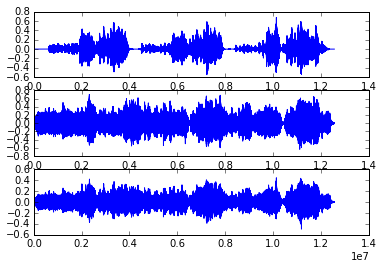

In [6]:
mix_vocal = sum(vocals)
mix_non_vocal = sum(non_vocals)
# Normalization
mix_vocal = mix_vocal/len(vocals)
mix_non_vocal = mix_non_vocal/len(non_vocals)
mix = 0.5*mix_vocal + 0.5*mix_non_vocal
# Plot
f, axarr = plt.subplots(3)
axarr[0].plot(mix_vocal)
axarr[1].plot(mix_non_vocal)
axarr[2].plot(mix)

In [7]:
# Take short time F
vocals_ft = stft(mix_vocal, FFT_SIZE, HOP_SIZE)
non_vocals_ft = stft(mix_non_vocal, FFT_SIZE, HOP_SIZE)
mix_ft = stft(mix, FFT_SIZE, HOP_SIZE)
# Cut in half
vocals_ft = vocals_ft[:, 0:vocals_ft.shape[1]/2 + 1]
non_vocals_ft = non_vocals_ft[:, 0:non_vocals_ft.shape[1]/2 + 1]
mix_ft = mix_ft[:, 0:mix_ft.shape[1]/2 + 1]
vocals_ft.shape

(24536L, 1025L)

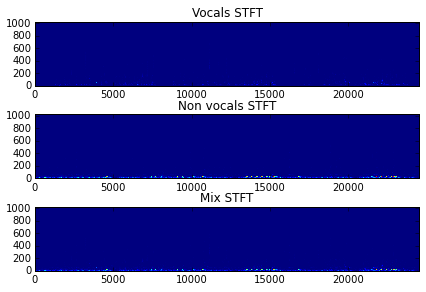

In [8]:
f, axarr = plt.subplots(3)
plt.tight_layout()
axarr[0].set_title('Vocals STFT')
axarr[0].imshow(scipy.absolute(vocals_ft.T), aspect='auto', origin='lower', interpolation='nearest')
axarr[1].set_title('Non vocals STFT')
axarr[1].imshow(scipy.absolute(non_vocals_ft.T), aspect='auto', origin='lower', interpolation='nearest')
axarr[2].set_title('Mix STFT')
axarr[2].imshow(scipy.absolute(mix_ft.T), aspect='auto', origin='lower', interpolation='nearest')

In [9]:
# Using only magnitude
mag_vocals_ft = scipy.absolute(vocals_ft)
mag_non_vocals_ft = scipy.absolute(non_vocals_ft)
mag_mix = scipy.absolute(mix_ft)
# Extract samples
vocal_frames = sample_frames(mag_vocals_ft, L, H)
non_vocal_frames = sample_frames(mag_non_vocals_ft, L, H)
mix_frames = sample_frames(mag_mix, L, H)

In [10]:
# Calculate ideal binary mask
ideal_binary_mask = (vocal_frames > non_vocal_frames).astype(int)

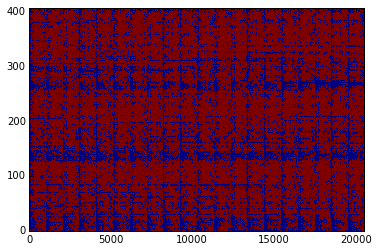

In [11]:
f, axarr = plt.subplots(1)
axarr.imshow(ideal_binary_mask, aspect='auto', origin='lower', interpolation='nearest')

In [12]:
# Ready the training samples
training_input = mix_frames / np.amax(mag_mix)
training_output = ideal_binary_mask
# Cut to 15k examples
training_input = training_input[0:15000,:]
training_output = training_output[0:15000,:]
print training_input.shape
print training_output.shape

(408L, 20500L)
(408L, 20500L)


In [16]:
# Prepare deep neural network
import lasagne
import theano.tensor as T
import theano

input_var = T.dtensor4('inputs')
target_var = T.dvector('targets')

layer_size = training_input.shape[1]

l_in = lasagne.layers.InputLayer(shape=(None, 1, layer_size, 1), input_var=input_var)
l_hidden = lasagne.layers.DenseLayer(l_in, num_units=(layer_size), nonlinearity=lasagne.nonlinearities.sigmoid)
l_out = lasagne.layers.DenseLayer(l_hidden, num_units=(layer_size), nonlinearity=lasagne.nonlinearities.sigmoid)
network = l_out

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(prediction, target_var)
loss = loss.mean()

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.squared_error(test_prediction, target_var)
test_loss = test_loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.1, momentum=0.5)

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [17]:
import time

# Train DNN
for epoch in range(N_EPOCHS):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for i in range(0, len(training_input.shape)):
        inputs, targets = training_input[i], training_output[i]
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for i in range(0, len(training_input.shape)):
        inputs, targets = training_input[i], training_output[i]
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

TypeError: ('Bad input argument to theano function with name "<ipython-input-16-64b5374805c8>:30"  at index 0(0-based)', 'Wrong number of dimensions: expected 4, got 1 with shape (20500L,).')